# Time Series Prediction using LSTM with PyTorch in Python 

Long Short Term Memory Networks are capable of capturing patterns in the time
series data, and therefore can be used to make predictions regarding the future trend of the data.

# Library

In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn.preprocessing import MinMaxScaler

# Dataset and Problem Definition

In [2]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


# plot the frequency

In [3]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

<IPython.core.display.Javascript object>


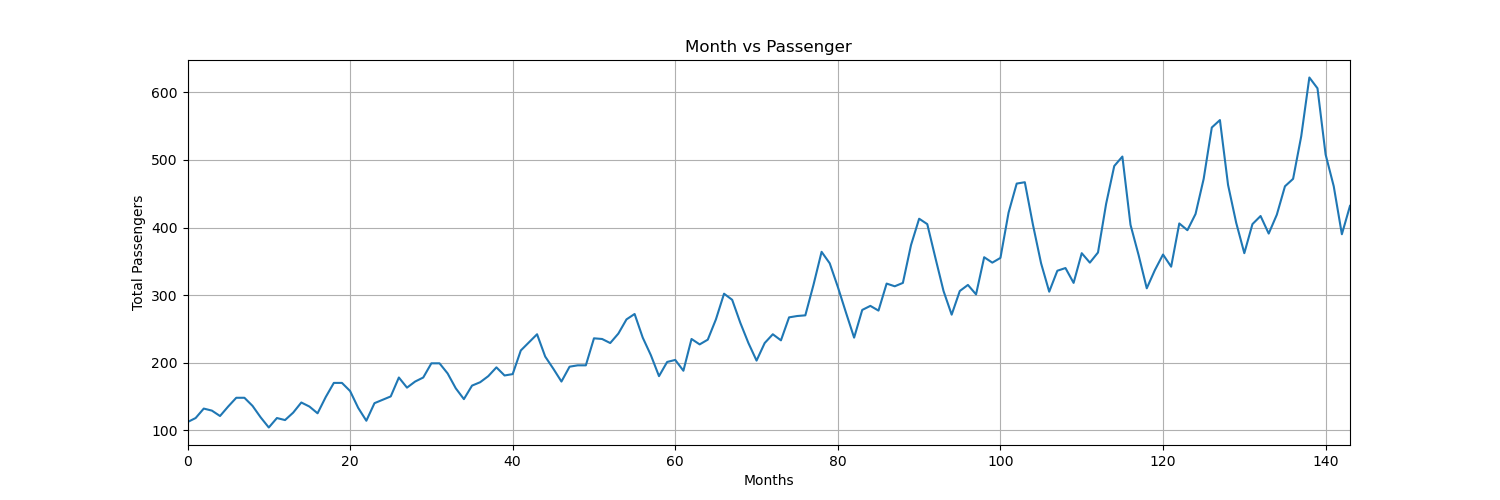

In [4]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])
plt.show()

# Data Preprocessing

It is very important to normalize the data for time series predictions

In [5]:
all_data = flight_data['passengers'].values.astype(float)
scaler = MinMaxScaler(feature_range=(-1, 1))
all_data = scaler.fit_transform(all_data.reshape(-1, 1))

# divide data

In [6]:
test_data_size = 12
# train_data = all_data_normalized[:-test_data_size]
# test_data = all_data_normalized[-test_data_size:]
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [7]:
print(len(train_data))
print(len(test_data))

132
12


In [8]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = train_data

# convert dataset into tensors

convert our dataset into tensors since Py Torch models are trained using tensors. To convert the dataset into tensors, we can simply pass our dataset to the constructor of the object. The final preprocessing step is to convert our training data into sequences and corresponding labels.

In [9]:
# train_data_normalized = torch.FloatTensor(train_data).view(-1)
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

You can use any sequence length and it depends upon the domain knowledge.
However, in our dataset it is convenient to use a sequence length of 12 since we have monthly data and there are 12 months in a year. If we had daily data, a better sequence length would have been 365, i.e. the number of days in a year. Therefore, we will set the input sequence length for training to 12. 

In [10]:
train_window = 12

The function will accept the raw input data and will return a list of tuples. In each tuple, the first element will contain list of 12 items corresponding to the number of passengers traveling in 12 months, the second tuple element will contain one item i.e. the number of passengers in the 12+1st month.

train_seq   -> every 12 (train_window) data from dataset
train_label -> next data after 12 (train_window) data from dataset

like time series problem, for next in train_seq the data will shift 1 data or more

In [11]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [12]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

# Creating LSTM Model 

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view
                                               (len(input_seq),1, -1),
                                               self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return (predictions[-1])

The constructor of the class accepts three parameters: 

1. input_size: Corresponds to the number of features in the input. Though our sequence length is 12, for each month we have only 1 value i.e. total number of passengers, therefore the input size will be 1.

2. hidden_layer_size: Specifies the number of hidden layers along with the number of neurons in each layer. We will have one layer of 100 neurons. 

3. output_size: The number of items in the output, since we want to predict the number of passengers for 1 month in the future, the output size will be 1.

in the constructor we create variables hidden_layer_size, lstm, linear, and 
hidden_cell. 

LSTM algorithm accepts three inputs: previous hidden state, previous cell, state and current input. 

The hidden_cell variable contains the previous hidden and cell state. 

The lstm and Linier layer variables are used to create the LSTM and linear layers. 

Inside the forward method, the input_seq is passed as a parameter, which is first passed through the lstm layer. 
The output of the lstm layer is passed to the linear layer. 

The predicted number of passengers is stored in the last item of the predictions list, which is returned to the calling function. 

In [14]:
#create an object of the LSTM() class
model = LSTM()
loss_function = nn.MSELoss()
# solving a classification problem, we will use the cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


# Training the Model 

In [16]:
epochs = 150
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.01650267
epoch:  26 loss: 0.00547946
epoch:  51 loss: 0.00126889
epoch:  76 loss: 0.00073193
epoch: 101 loss: 0.00917145
epoch: 126 loss: 0.00675053
epoch: 149 loss: 0.0017218408


# Making Predictions

Since our test set contains the passenger data for the last 12 months and our model is trained to make predictions using a sequence length of 12. We will first filter the last 12 values from the training set: 

In [17]:
fut_pred = 12
test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.011583011597394943, -0.0810810774564743, 0.1660231649875641, 0.12741312384605408, 0.22007721662521362, 0.42084941267967224, 0.7142857313156128, 0.7567567825317383, 0.3861003816127777, 0.16988417506217957, -0.0038610037881881, 0.1621621549129486]


inside a loop these 12 items will be used to make predictions about the first item from the test set i.e. the item number 133. The predict value will then be appended to the  test_inputs list. During the second iteration, again the last 12 items will be used as input and a new prediction will be made which will then be appended to the test_inputs list again. The for loop will execute for 12 times since there are 12 elements in the test set. At the end of the
loop the test_inputs list will contain 24 items. The last 12 items will be the predicted values for the test set. 

In [18]:
model.eval()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [19]:
test_inputs[fut_pred:]

[0.7562856078147888,
 0.632013201713562,
 0.30182456970214844,
 0.9680036306381226,
 1.31577730178833,
 1.308899998664856,
 0.8019859790802002,
 0.12105584144592285,
 -0.02678494155406952,
 0.10223279893398285,
 0.6124594211578369,
 1.1234387159347534]

Since we normalized the dataset for training, the predicted values are also normalized. We need to convert the normalized predicted values into actual predicted values. We can do so by passing the normalized values to the 
method of the min/max scaler object that we used to normalize our dataset. 

In [20]:
actual_predictions = scaler.inverse_transform(np.array(
                                    test_inputs[train_window:] ).reshape(-1,1))
print(actual_predictions)

[[558.87797242]
 [526.69141924]
 [441.17256355]
 [613.71294034]
 [703.78632116]
 [702.00509965]
 [570.71436858]
 [394.35346293]
 [356.06270014]
 [389.47829492]
 [521.62699008]
 [653.97062743]]


<IPython.core.display.Javascript object>


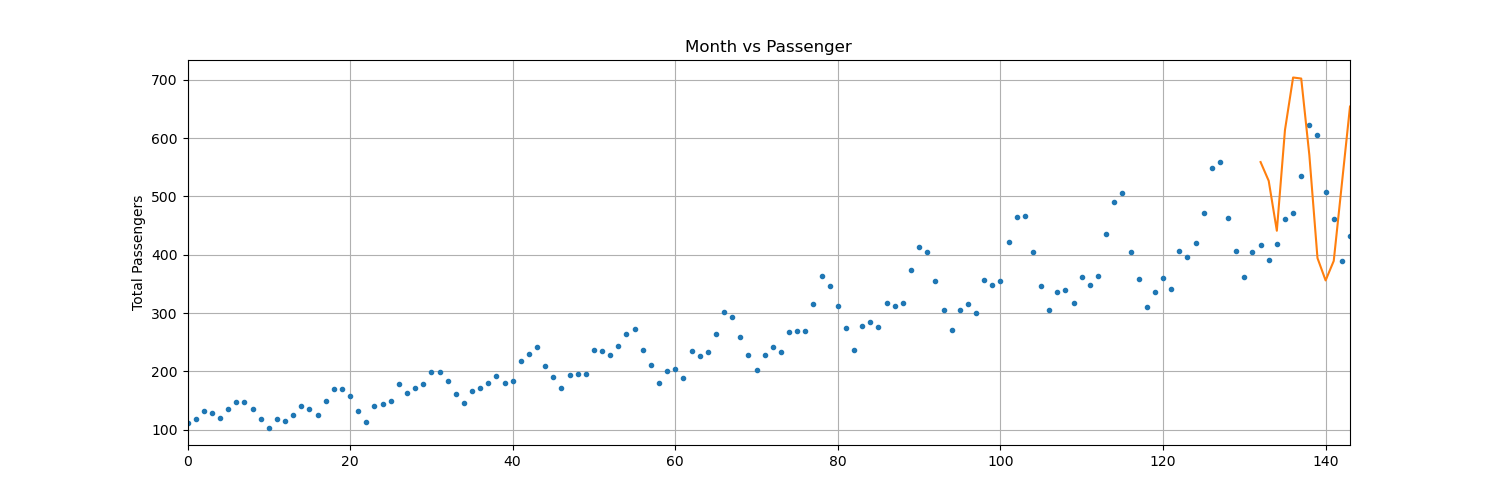

In [21]:
x = np.arange(132, 144, 1)
fig = plt.figure()
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'],".")
plt.plot(x,actual_predictions)
plt.show()

<IPython.core.display.Javascript object>


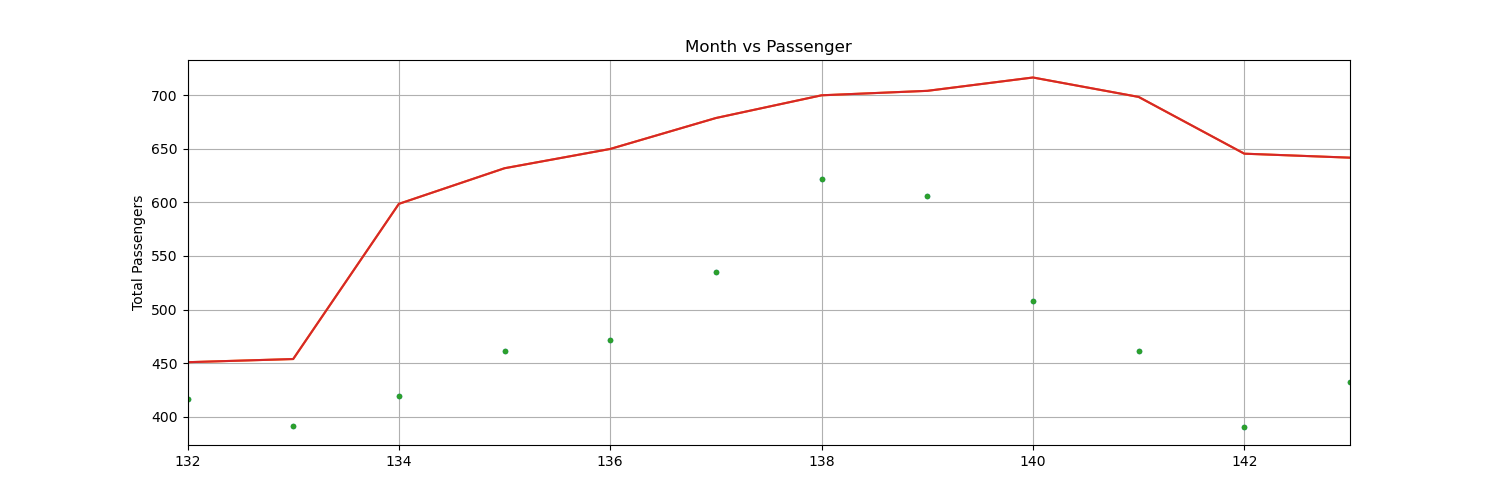

In [51]:
fig = plt.figure()
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'][-train_window:],".")
plt.plot(x,actual_predictions)
plt.show()

<IPython.core.display.Javascript object>


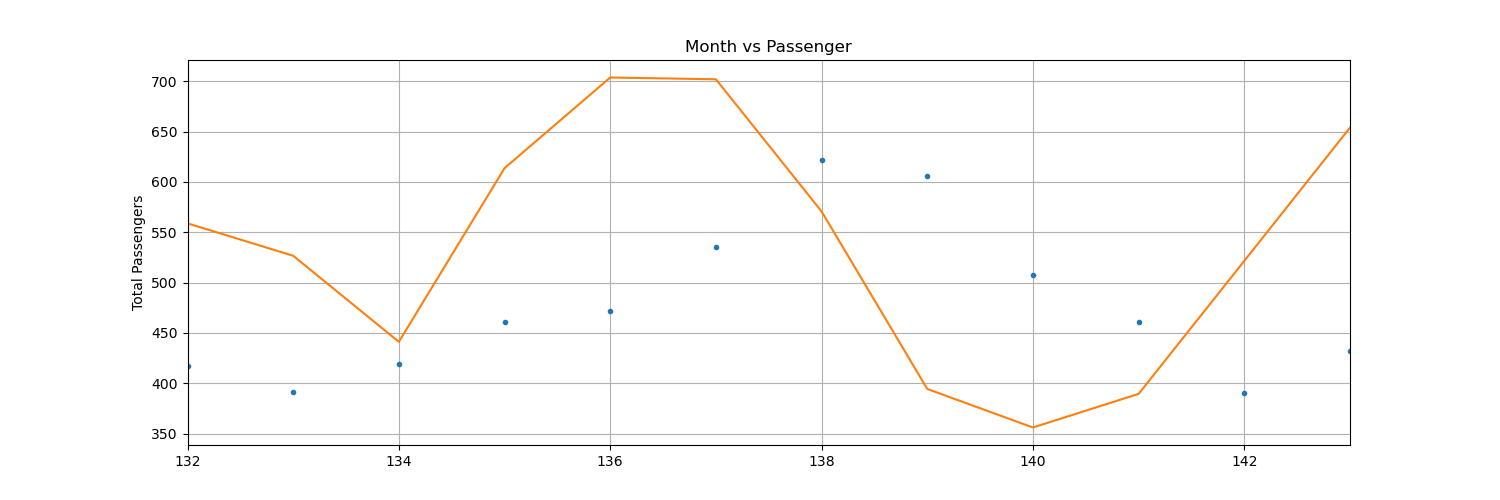

In [23]:
actual_predictions_1 = actual_predictions
fig = plt.figure()
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'][-train_window:],".")
plt.plot(x,actual_predictions_1)
# plt.plot(x,actual_predictions)
plt.show()